# DDA 4230 Tutorial 5

## Section 0:  Outline
1. Implement the Bernoulli Multi-arm bandits (MAB) environment 
2. Implement & test Thompson Sampling Method
3. Introduction to Gym
4. Implement & test Policy Evaluation
5. Exercise


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandits_alg import eps_greedy, ETC, UCB

## Section 1: MAB Environment
Input
1. m_arm: Number of arms
2. p: expectation of each arm

Methods
1. act(action): Select arm 'action' and return the observed reward


In [2]:
class Bandit:
    def __init__(self, m_arm=10, p=None):
        self.m = m_arm
        if p:
            self.p = p
            assert self.m == len(self.p), 'Number of arms must equal to numer of probabilities'
        else:
            self.p = np.random.random_sample(self.m)
        self.max_prob = np.amax(self.p)
        self.optimal_arm = np.argmax(self.p)

    def act(self, action):
        return np.random.binomial(1, p=self.p[action])

    def regret(self, action):
        return self.max_prob - self.p[action]

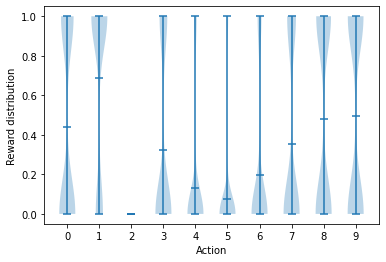

The Best Arm is 1 with mean 0.7203244934421581


In [3]:
np.random.seed(1)
m = 10
bandit_Bernoulli = Bandit(m_arm=m)
data_set = np.zeros([200, m])
for i in range(m):
    for j in range(200):
        data_set[j, i] = bandit_Bernoulli.act(i)
plt.violinplot(data_set, showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.xticks(list(range(1, 11)), list(range(10)))
plt.show()
print('The Best Arm is', bandit_Bernoulli.optimal_arm,
      'with mean', bandit_Bernoulli.max_prob)

## Section 2: Thompson Sampling Algorithm

<img src="https://i.loli.net/2021/03/09/6xcnm9Ye5iVf3Od.png" style="width: 800px;" center/>

Input
1. bandits: Bernoulli MAB environment
2. T: Horizon

Return
1. q_hat: Reward estimation for each arm (optional)
2. avg_return_list: average return over time (optional)



In [4]:
def sample_bandit_distribution(beta_parameter):
    """Sample theta from Beta distribution

    Parameters
    ----------
    beta_parameter: np.array[m，2]
        Parameters of Beta distribution

    Returns
    -------
    theta: np.ndarray[m]
        Value of theta for each arm
    """
    theta = np.random.beta(beta_parameter[0, :], beta_parameter[1, :])
    return theta


def Thompson_sampling(bandits, T=1000):
    m = bandits.m
    # Reward estimation (Optional)
    N = np.zeros(m)
    q_hat = np.zeros(m)
    avg_return = 0
    avg_return_list = np.zeros(T)

    # Initialize Prior Parameters
    beta_parameter = np.ones((m, 2))

    for t in range(0, T):
        # Sample theta from Bets distribution
        theta = sample_bandit_distribution(beta_parameter)
        action = np.argmax(theta)
        reward = bandits.act(action)

        # Update Beta Parameters
        if reward == 1:
            beta_parameter[action, 0] += 1
        else:
            beta_parameter[action, 1] += 1

        # Reward estimation (Optional)
        q_hat[action] = (q_hat[action]*N[action]+reward)/(N[action]+1)
        N[action] += 1
        avg_return += (reward-avg_return)/(t+1)
        avg_return_list[t] = avg_return
    return q_hat, avg_return_list

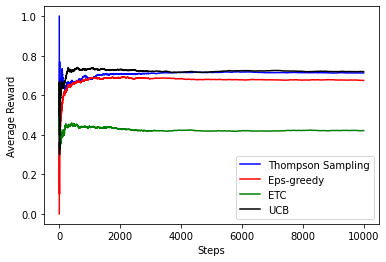

In [10]:
T = 10000
q_hat_ts, avg_return_list_ts = Thompson_sampling(bandit_Bernoulli, T=T)
q_hat_eps, avg_return_list_eps = eps_greedy(bandit_Bernoulli, eps=0.1, T=T)
q_hat_etc, avg_return_list_etc = ETC(bandit_Bernoulli, k=5, T=T)
q_hat_ucb, avg_return_list_ucb = UCB(bandit_Bernoulli, sigma=1, T=T)
plt.plot(np.arange(T), avg_return_list_ts, c='blue')
plt.plot(np.arange(T), avg_return_list_eps, c='red')
plt.plot(np.arange(T), avg_return_list_etc, c='green')
plt.plot(np.arange(T), avg_return_list_ucb, c='black')

plt.legend(["Thompson Sampling", "Eps-greedy", "ETC", "UCB"])

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

## Section 3: Introduction to Gym

### What is Gym?

**Gym is a toolkit for developing and comparing reinforcement learning algorithms.** It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano.



### Installation
```
pip install gym
```
### Environments
The gym library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms such as ***2D and 3D robots***, ***Atari Games***, and ***Classic control tasks***. These environments have a shared interface, allowing you to write general algorithms. 
 
The environment list can be found [here](https://gym.openai.com/envs/).

In [11]:
import gym
# Create Environment
env = gym.make('Taxi-v3')
# Reset
env.reset()
for _ in range(1):
    env.render()
    env.step(env.action_space.sample())  # take a random action
env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### Observations

Gym's environments are implementations of the classic “agent-environment loop”. Each timestep, the agent chooses an action, and the environment returns an observation and a reward. 

The environment’s ```step``` function returns  four values. These are:

* ***observation (object)***: an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.

* ***reward (float)***: amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.

* ***done (boolean)***: whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)

* ***info (dict)***: diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

### Space
Every environment comes with an ***action_space*** and an ***observation_space***. These attributes are of type Space, and they describe the format of valid actions and observations:

In [12]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


The Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0 or 1. The Box space represents an n-dimensional box, so valid observations will be an array of 4 numbers. We can also check the Box’s bounds:

In [13]:
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


## Section 4: Policy Evaluation

<img src="https://i.loli.net/2021/03/09/fOu3mWztpgGnVcE.png" style="width: 800px;" center/>

Input
1. P: transition matrix
2. $\pi$: Policy

Return
1. $V^{\pi}$: Value function estimation



In [22]:
"""
For policy_evaluation, the parameters P, nS, nA, gamma are defined as follows:

    P: nested dictionary
        From gym.core.Environment
        For each pair of states in [1, nS] and actions in [1, nA], P[state][action] is a
        tuple of the form (probability, nextstate, reward, terminal) where
            - probability: float
                the probability of transitioning from "state" to "nextstate" with "action"
            - nextstate: int
                denotes the state we transition to (in range [0, nS - 1])
            - reward: int
                either 0 or 1, the reward for transitioning from "state" to
                "nextstate" with "action"
            - terminal: bool
              True when "nextstate" is a terminal state (hole or goal), False otherwise
    nS: int
        number of states in the environment
    nA: int
        number of actions in the environment
    gamma: float
        Discount factor. Number in range [0, 1)
"""


def policy_evaluation(P, nS, nA, policy, gamma=0.9, tol=1e-3):
    """Evaluate the value function from a given policy.

    Parameters
    ----------
    P, nS, nA, gamma:
        defined at beginning of file
    policy: np.array[nS，nA]
        The policy to evaluate. Maps states to actions.
    tol: float
        Terminate policy evaluation when max |value_function(s) - prev_value_function(s)| < tol
    Returns
    -------
    value_function: np.ndarray[nS]
        The value function of the given policy, where value_function[s] is the value of state s
    """

    value_function = np.zeros(nS)

    iteration = 0
    while iteration < 1e5:
        iteration += 1
        delta = 0
        ############################
        # YOUR IMPLEMENTATION HERE #
        for s in range(nS):
            last_v = value_function[s]
            v_p = 0
            for a in range(nA):
                transitions = P[s][a]
                v_a = np.array([t[0]*(t[2]+gamma*value_function[t[1]])
                                for t in transitions])
                v_p += policy[s, a]*(np.sum(v_a))
            value_function[s] = v_p
            delta = max(delta, abs(last_v-value_function[s]))
        ############################
        if delta < tol:
            break
    #print('Number of Iteration:', iteration)
    return value_function

### FrozenLake-v0
The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.



In [23]:
'''
FrozenLake
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
'''
# Create Environment
env = gym.make('FrozenLake-v0')
# Reset
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [24]:
print(env.nA)
print(env.action_space)
print(env.nS)
print(env.observation_space)

4
Discrete(4)
16
Discrete(16)


In [25]:
nA = env.nA
nS = env.nS
P = env.P

policy = np.ones((nS, nA))/nA  # Uniform Policy
V_pi = policy_evaluation(P, nS, nA, policy, gamma=0.9, tol=1e-3)
print(V_pi)

Number of Iteration: 9
[0.00258989 0.0031589  0.00918745 0.0035199  0.00557057 0.
 0.02597257 0.         0.0178311  0.05701284 0.10659143 0.
 0.         0.12984305 0.39111747 0.        ]


## Section 5: Exercise

FrozenLake-v0 is a episodic task and an episode terminates when the agent find a path or fall into the water. 

Modify the environment so that any action in terminal states lead the agent to start state, i.e., S.

Find the value function of uniform policy in the new environment.

In [21]:
nA = env.nA
nS = env.nS
P = env.P
terminal_states = [5, 7, 11, 12, 15]
redirect_dic = {0: [(1.0, 0, 0, False)],  1: [(1.0, 0, 0, False)],  2: [
    (1.0, 0, 0, False)],  3: [(1.0, 0, 0, False)]}
for state in terminal_states:
    P[state] = redirect_dic

policy = np.ones((nS, nA))/nA  # Uniform Policy
V_pi = policy_evaluation(P, nS, nA, policy, gamma=0.9, tol=1e-3)

print(V_pi)


9
[0.00273357 0.00368514 0.00957587 0.00414393 0.0061519  0.00246021
 0.02713998 0.00246021 0.01858331 0.05801454 0.10760133 0.00246021
 0.00246021 0.13089628 0.39210353 0.00246021]
